In [1]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
# from dataset import KaggleDataset
import torchvision.transforms.functional as tx
from model import YOLOv1
from loss import Loss
import cv2
import os
import numpy as np
import math
from datetime import datetime
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import torchvision
from sklearn.utils import shuffle
import torch.nn as nn
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.tensorboard import SummaryWriter

In [2]:
init_lr = 0.001
base_lr = 0.01
momentum = 0.9
weight_decay = 5.0e-4
num_epochs = 135
batch_size = 1
few_data = False
data_num = 3000
image_dir = "../data/image/"

# Path to label files.
train_label = '../data/train.txt'
valid_label = '../data/valid.txt'

In [3]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
print(model_conv)
model_conv = nn.Sequential(*(list(model_conv.children())[:-2]))
yolo = YOLOv1(model_conv, num_classes=1)




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
def decode(pred_tensor):
        """ Decode tensor into box coordinates, class labels, and probs_detected.
        Args:
            pred_tensor: (tensor) tensor to decode sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
        Returns:
            boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...]. Normalized from 0.0 to 1.0 w.r.t. image width/height, sized [n_boxes, 4].
            labels: (tensor) class labels for each detected boxe, sized [n_boxes,].
            confidences: (tensor) objectness confidences for each detected box, sized [n_boxes,].
            class_scores: (tensor) scores for most likely class for each detected box, sized [n_boxes,].
        """
        conf_thresh = 0
        prob_thresh = 0
        nms_thresh = 0.45
        S, B, C = 7, 2, 1
        boxes, labels, confidences, class_scores = [], [], [], []

        cell_size = 1.0 / float(S)

        conf = pred_tensor[:, :, 4].unsqueeze(2) # [S, S, 1]
        for b in range(1, B):
            conf = torch.cat((conf, pred_tensor[:, :, 5*b + 4].unsqueeze(2)), 2)
        conf_mask = conf > conf_thresh # [S, S, B]

        # TBM, further optimization may be possible by replacing the following for-loops with tensor operations.
        for i in range(S): # for x-dimension.
            for j in range(S): # for y-dimension.
                class_score, class_label = torch.max(pred_tensor[j, i, 5*B:], 0)

                for b in range(B):
                    conf = pred_tensor[j, i, 5*b + 4]
                    prob = conf * class_score
                    if float(prob) < prob_thresh:
                        continue

                    # Compute box corner (x1, y1, x2, y2) from tensor.
                    box = pred_tensor[j, i, 5*b : 5*b + 4]
                    x0y0_normalized = torch.FloatTensor([i, j]) * cell_size # cell left-top corner. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    xy_normalized = box[:2] * cell_size + x0y0_normalized   # box center. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    wh_normalized = box[2:] # Box width and height. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    box_xyxy = torch.FloatTensor(4) # [4,]
                    box_xyxy[:2] = xy_normalized - 0.5 * wh_normalized # left-top corner (x1, y1).
                    box_xyxy[2:] = xy_normalized + 0.5 * wh_normalized # right-bottom corner (x2, y2).
                    box_xyxy[:2] *= 448 
                    box_xyxy[2:] *= 448
                    # Append result to the lists.
                    boxes.append(box_xyxy)
                    labels.append(class_label)
                    confidences.append(conf)
                    class_scores.append(class_score)

        if len(boxes) > 0:
            boxes = torch.stack(boxes, 0) # [n_boxes, 4]
            labels = torch.stack(labels, 0)             # [n_boxes, ]
            confidences = torch.stack(confidences, 0)   # [n_boxes, ]
            class_scores = torch.stack(class_scores, 0) # [n_boxes, ]
        else:
            # If no box found, return empty tensors.
            boxes = torch.FloatTensor(0, 4)
            labels = torch.LongTensor(0)
            confidences = torch.FloatTensor(0)
            class_scores = torch.FloatTensor(0)

        return boxes, labels, confidences, class_scores

In [6]:
# yolo.load_state_dict(torch.load("../data/model/"+date+"/last_model.pth"))
date = "12_5_1"
yolo.load_state_dict(torch.load("../data/model/"+date+"/best_MSE_model.pth"))
# yolo.load_state_dict(torch.load("../data/model/"+date+"/last_model.pth"))

<All keys matched successfully>

In [19]:
mode = "valid"
test_img_files = open('../data/'+mode+'.txt')
length = 0
for line in test_img_files:
    length+=1

In [20]:
global_mean = [158.122433332762, 135.86361008407835, 118.4334553918209]
global_std = [58.57134455799642, 58.4258764351661, 59.034157439521465] 

91
tensor(0.6706, grad_fn=<SelectBackward0>)
253 213 326 264 20210924093227_pid2625_oa88Zx.jpg


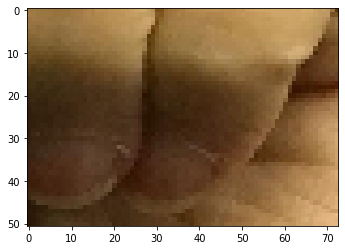

tensor(0.4530, grad_fn=<SelectBackward0>)
77 182 139 224 20210924094432_pid2625_n7ARIU.jpg


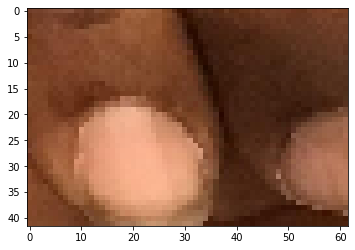

tensor(0.6677, grad_fn=<SelectBackward0>)
209 123 271 177 20210924095628_pid2625_FmAJKK.jpg


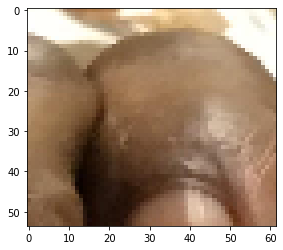

tensor(0.7149, grad_fn=<SelectBackward0>)
204 184 277 247 20210924100858_pid2625_77y4MY.jpg


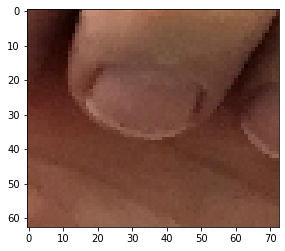

tensor(0.5473, grad_fn=<SelectBackward0>)
170 144 250 201 20210924102105_pid2625_Q5qwb3.jpg


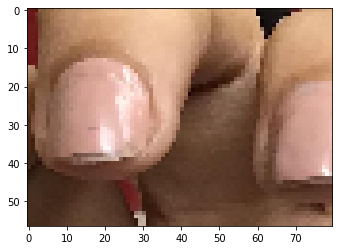

tensor(0.7887, grad_fn=<SelectBackward0>)
72 113 129 169 20210924110435_pid2625_6z7f9u.jpg


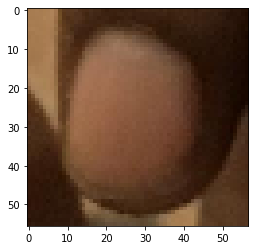

tensor(0.5163, grad_fn=<SelectBackward0>)
187 136 271 218 20210924111859_pid2625_zSPGCe.jpg


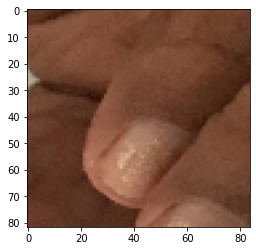

tensor(0.5663, grad_fn=<SelectBackward0>)
187 142 264 197 20210924112946_pid2625_RK5MCB.jpg


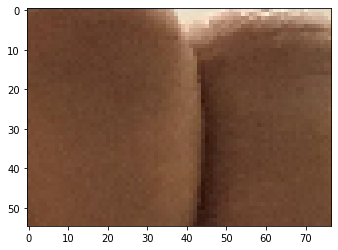

tensor(0.6420, grad_fn=<SelectBackward0>)
130 179 195 237 20210924114018_pid2625_gvJKBp.jpg


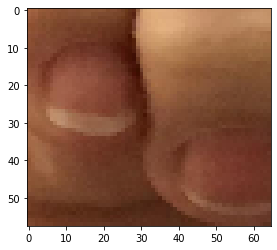

tensor(0.5936, grad_fn=<SelectBackward0>)
128 204 198 242 20210928151714_pid2625_C9TPrC.jpg


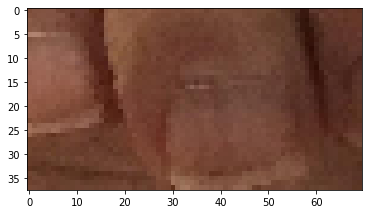

tensor(0.5921, grad_fn=<SelectBackward0>)
210 203 275 255 20210928153650_pid2625_LWhL2Q.jpg


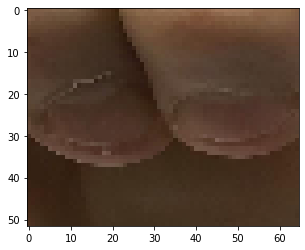

tensor(0.4883, grad_fn=<SelectBackward0>)
196 163 243 210 20210928154918_pid2625_IR9fFi.jpg


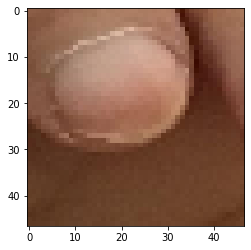

tensor(0.6704, grad_fn=<SelectBackward0>)
271 188 331 224 20210928162105_pid2625_NFf3a6.jpg


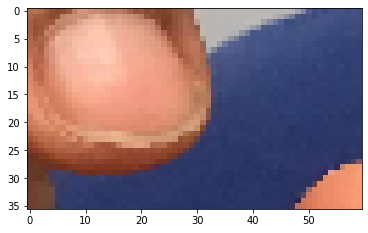

tensor(0.6343, grad_fn=<SelectBackward0>)
218 178 266 229 20210928162411_pid2625_iibAi3.jpg


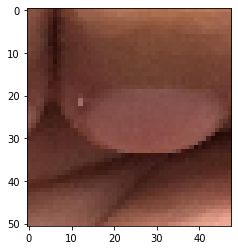

tensor(0.6483, grad_fn=<SelectBackward0>)
182 143 262 200 20210928163606_pid2625_hYymr8.jpg


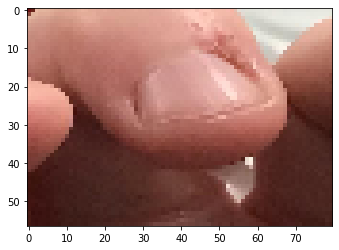

tensor(0.5432, grad_fn=<SelectBackward0>)
198 196 268 240 20210928165052_pid2625_nkIhwX.jpg


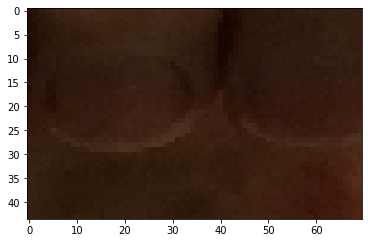

tensor(0.7115, grad_fn=<SelectBackward0>)
129 126 207 182 20210928173904_pid2625_TY6gca.jpg


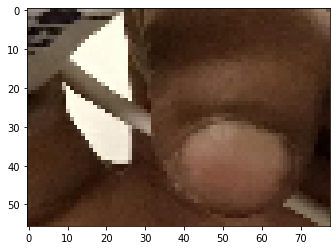

tensor(0.6304, grad_fn=<SelectBackward0>)
197 243 277 290 20211001093945_pid2625_u5wkRG.jpg


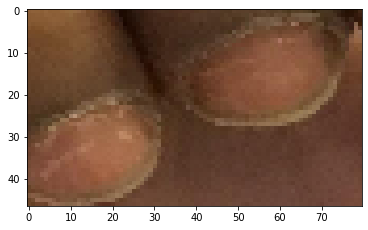

tensor(0.4162, grad_fn=<SelectBackward0>)
300 137 379 205 20211001095106_pid2625_oSsEbW.jpg


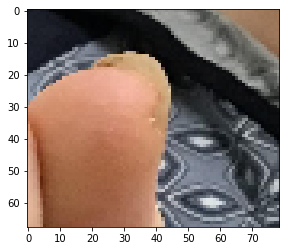

tensor(0.4986, grad_fn=<SelectBackward0>)
194 242 272 296 20211001100222_pid2625_VwmejE.jpg


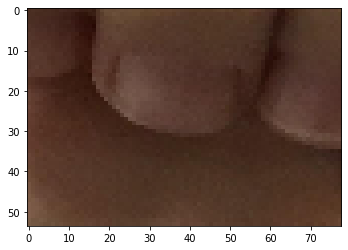

tensor(0.5393, grad_fn=<SelectBackward0>)
236 203 335 258 20211001102619_pid2625_GvuGJY.jpg


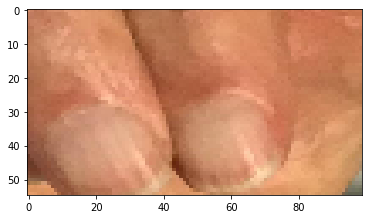

tensor(0.6272, grad_fn=<SelectBackward0>)
289 239 370 298 20211001103904_pid2625_xqE5UG.jpg


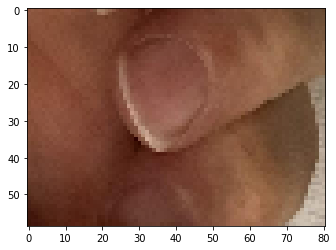

tensor(0.4566, grad_fn=<SelectBackward0>)
43 118 122 177 20211001104950_pid2625_vqrTPT.jpg


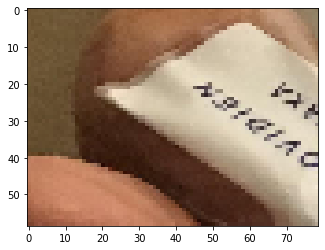

tensor(0.6647, grad_fn=<SelectBackward0>)
202 271 271 314 20211001110637_pid2625_d7cR6A.jpg


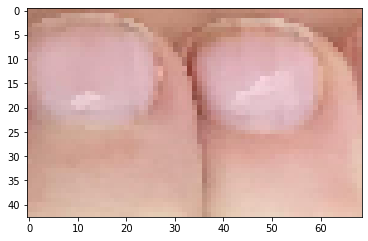

tensor(0.7003, grad_fn=<SelectBackward0>)
273 209 332 249 20211001114152_pid2625_UIkoXG.jpg


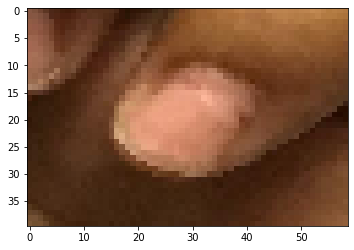

tensor(0.4862, grad_fn=<SelectBackward0>)
58 316 149 392 20211001115403_pid2625_ECUig3.jpg


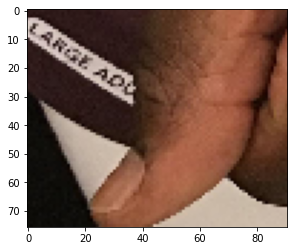

tensor(0.5226, grad_fn=<SelectBackward0>)
145 187 204 232 20211001120605_pid2625_iJ7Wad.jpg


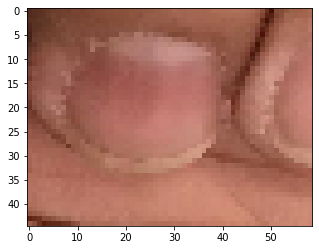

tensor(0.4676, grad_fn=<SelectBackward0>)
237 220 309 265 20211001121841_pid2625_bI52T2.jpg


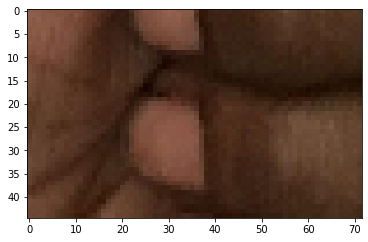

tensor(0.4985, grad_fn=<SelectBackward0>)
200 279 259 327 20211005153815_pid2625_CoM2x4.jpg


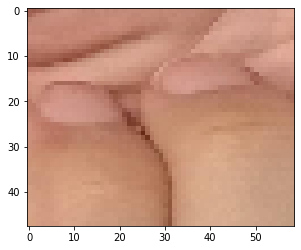

tensor(0.6594, grad_fn=<SelectBackward0>)
203 268 276 334 20211005155237_pid2625_GW4JMV.jpg


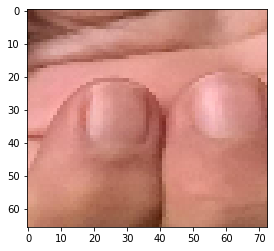

tensor(0.5584, grad_fn=<SelectBackward0>)
277 195 326 245 20211005160552_pid2625_Ivr2oc.jpg


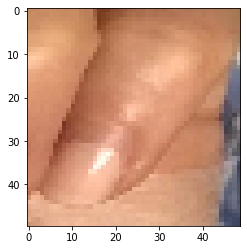

tensor(0.5836, grad_fn=<SelectBackward0>)
225 195 312 254 20211005161851_pid2625_Wxm9NQ.jpg


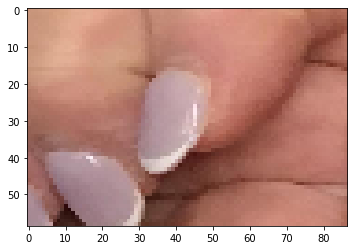

tensor(0.5803, grad_fn=<SelectBackward0>)
251 286 311 330 20211005162921_pid2625_J2ebyh.jpg


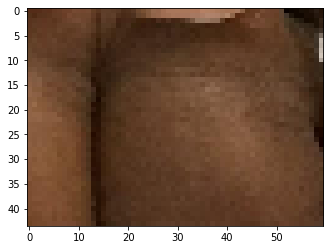

tensor(0.4718, grad_fn=<SelectBackward0>)
205 271 278 318 20211005163745_pid2625_UG2g4X.jpg


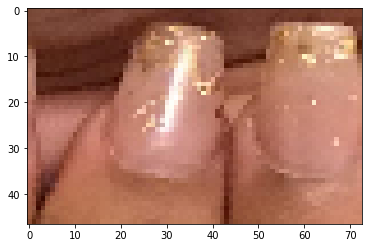

tensor(0.4343, grad_fn=<SelectBackward0>)
275 235 347 285 20211005172553_pid2625_uVq5pp.jpg


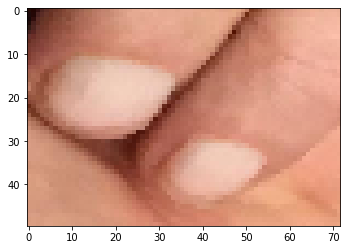

tensor(0.4901, grad_fn=<SelectBackward0>)
190 142 276 199 20211005173559_pid2625_ipx5ey.jpg


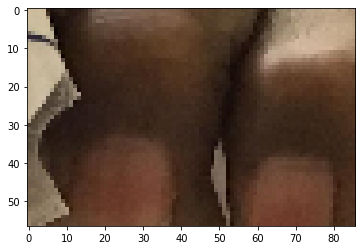

tensor(0.5413, grad_fn=<SelectBackward0>)
304 192 380 245 20211008113055_pid2625_5EMJEY.jpg


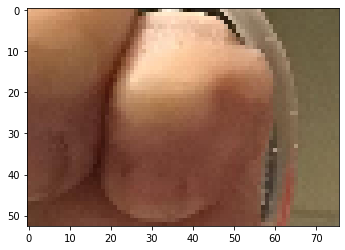

tensor(0.5868, grad_fn=<SelectBackward0>)
191 318 260 374 20211008114424_pid2625_wG4nSk.jpg


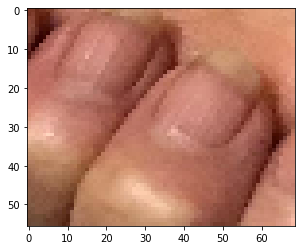

tensor(0.4357, grad_fn=<SelectBackward0>)
209 65 267 113 20211008115848_pid2625_h3kMpI.jpg


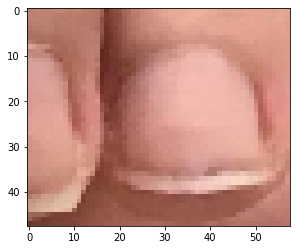

tensor(0.5435, grad_fn=<SelectBackward0>)
180 321 251 370 20211008122924_pid2625_UDXbMF.jpg


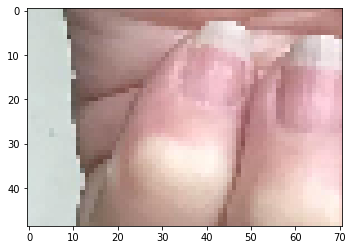

tensor(0.3868, grad_fn=<SelectBackward0>)
260 332 347 384 20211008123123_pid2625_XNnzgB.jpg


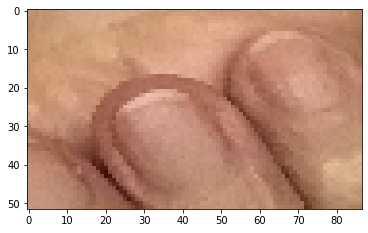

tensor(0.6825, grad_fn=<SelectBackward0>)
189 252 253 313 20211012151815_pid2625_jISVZ3.jpg


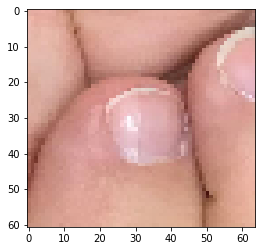

tensor(0.5148, grad_fn=<SelectBackward0>)
179 283 242 332 20211012153629_pid2625_6N7t9Q.jpg


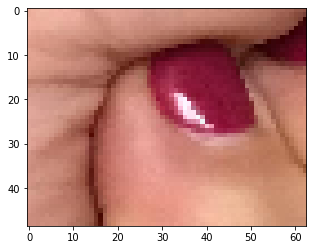

tensor(0.5585, grad_fn=<SelectBackward0>)
208 223 265 268 20211012154950_pid2625_wkvizc.jpg


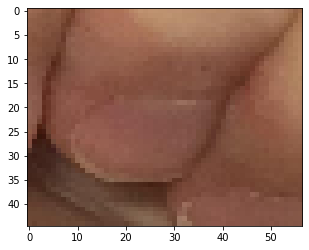

tensor(0.6532, grad_fn=<SelectBackward0>)
191 280 249 314 20211012161255_pid2625_hf5gbs.jpg


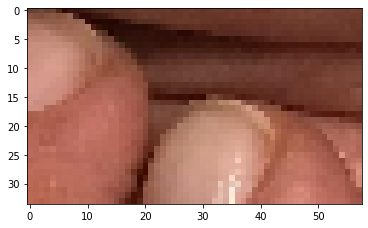

tensor(0.6937, grad_fn=<SelectBackward0>)
180 205 252 258 20211012163257_pid2625_VDjoIn.jpg


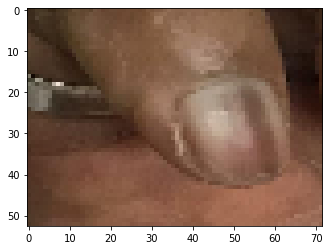

tensor(0.6746, grad_fn=<SelectBackward0>)
216 204 268 247 20211012165054_pid2625_UjDR27.jpg


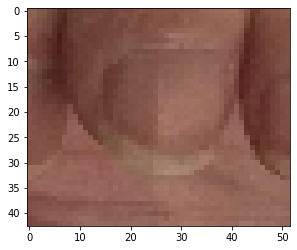

tensor(0.5784, grad_fn=<SelectBackward0>)
71 198 134 254 20211012171048_pid2625_4F6t83.jpg


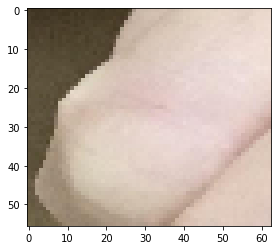

tensor(0.7037, grad_fn=<SelectBackward0>)
241 324 313 365 20211012172601_pid2625_8rYcia.jpg


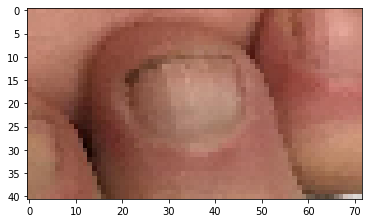

tensor(0.5803, grad_fn=<SelectBackward0>)
220 246 276 303 20211015094041_pid2625_cvCeER.jpg


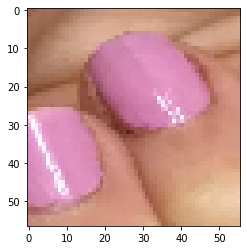

tensor(0.6786, grad_fn=<SelectBackward0>)
124 138 201 190 20211015100101_pid2625_7NLSDY.jpg


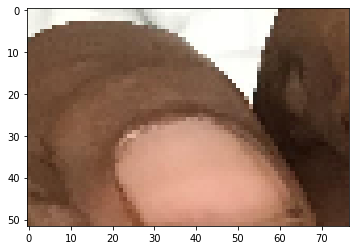

tensor(0.7328, grad_fn=<SelectBackward0>)
106 321 175 378 20211015101452_pid2625_TnyXKL.jpg


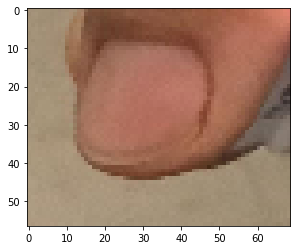

tensor(0.4116, grad_fn=<SelectBackward0>)
209 288 267 332 20211015104622_pid2625_jQRzwB.jpg


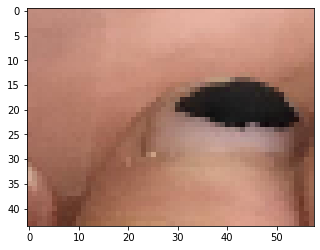

tensor(0.6536, grad_fn=<SelectBackward0>)
53 279 121 325 20211015110600_pid2625_EM4cMj.jpg


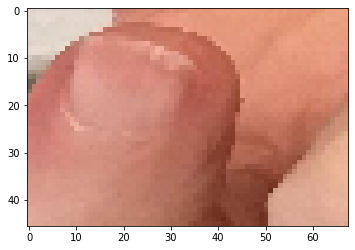

tensor(0.6892, grad_fn=<SelectBackward0>)
132 278 183 323 20211015111744_pid2625_jrH5WF.jpg


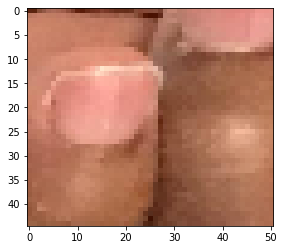

tensor(0.5116, grad_fn=<SelectBackward0>)
137 221 209 279 20211019140342_pid2625_fwkrj4.jpg


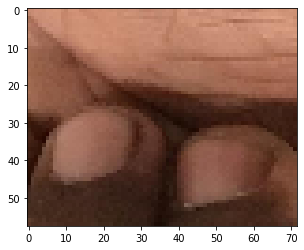

tensor(0.7163, grad_fn=<SelectBackward0>)
136 208 216 265 20211019141835_pid2625_SHQuYb.jpg


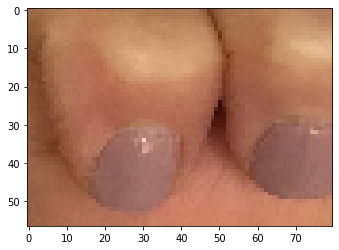

tensor(0.7621, grad_fn=<SelectBackward0>)
89 277 140 328 20211019143426_pid2625_qboFoA.jpg


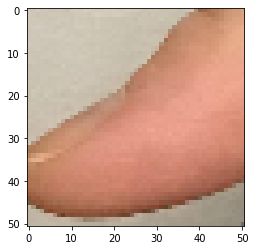

tensor(0.5623, grad_fn=<SelectBackward0>)
205 263 287 320 20211019150005_pid2625_Dgiyq3.jpg


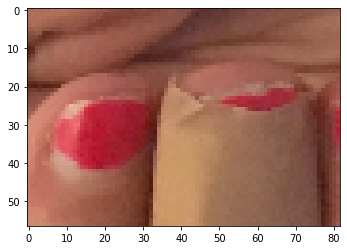

tensor(0.5510, grad_fn=<SelectBackward0>)
175 210 249 264 20211019152110_pid2625_2RNHNW.jpg


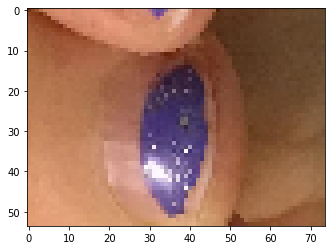

tensor(0.4949, grad_fn=<SelectBackward0>)
209 174 276 231 20211019154109_pid2625_uqQPXF.jpg


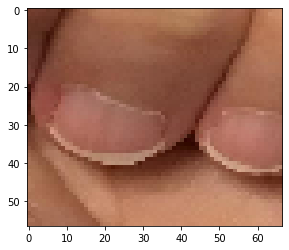

tensor(0.6607, grad_fn=<SelectBackward0>)
209 174 272 224 20211019163134_pid2625_q3QqhL.jpg


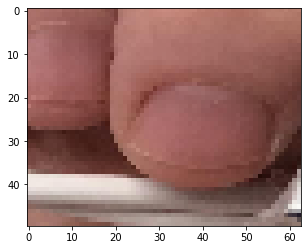

tensor(0.8030, grad_fn=<SelectBackward0>)
135 205 219 264 20211021092245_pid2625_afRC3w.jpg


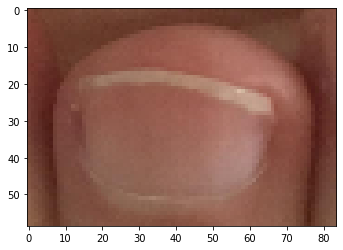

tensor(0.7455, grad_fn=<SelectBackward0>)
284 303 336 363 20211022095237_pid2625_sWAkey.jpg


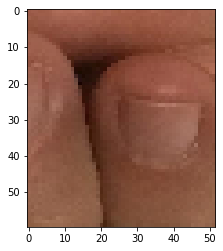

tensor(0.7507, grad_fn=<SelectBackward0>)
255 252 322 309 20211022100251_pid2625_5KWFLM.jpg


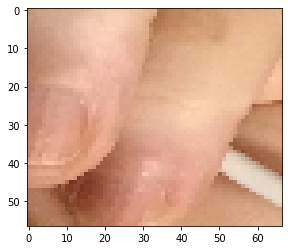

tensor(0.7874, grad_fn=<SelectBackward0>)
162 254 238 309 20211022101259_pid2625_auKhI9.jpg


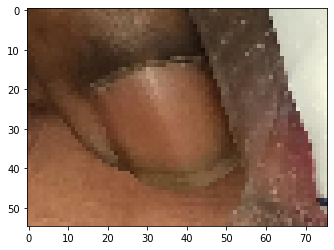

tensor(0.6868, grad_fn=<SelectBackward0>)
140 307 196 353 20211022102517_pid2625_zYbp3A.jpg


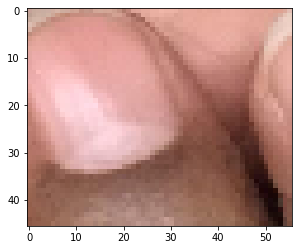

tensor(0.6638, grad_fn=<SelectBackward0>)
181 264 251 322 20211022103453_pid2625_GUr4qc.jpg


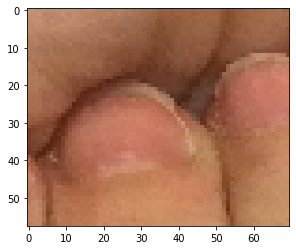

tensor(0.6413, grad_fn=<SelectBackward0>)
178 213 252 280 20211022105154_pid2625_Se4vCP.jpg


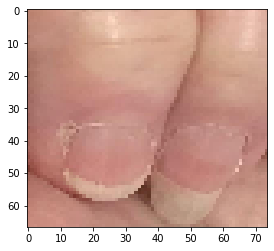

tensor(0.6371, grad_fn=<SelectBackward0>)
298 224 356 262 20211022110008_pid2625_9Kh72Y.jpg


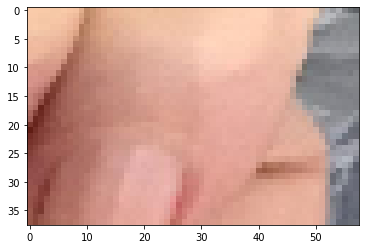

tensor(0.4744, grad_fn=<SelectBackward0>)
199 118 278 177 20211022113205_pid2625_MMwg92.jpg


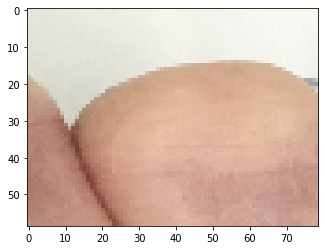

tensor(0.6485, grad_fn=<SelectBackward0>)
199 174 269 220 20211022114440_pid2625_ZaEstM.jpg


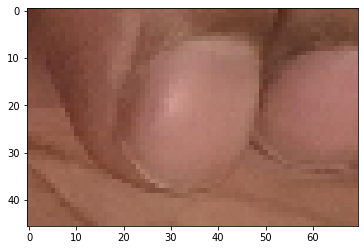

tensor(0.5490, grad_fn=<SelectBackward0>)
205 208 263 256 20211022122135_pid2625_VQhtQA.jpg


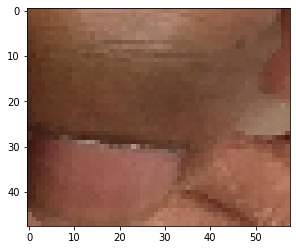

tensor(0.5902, grad_fn=<SelectBackward0>)
325 274 387 333 20211026151937_pid2625_QznJWd.jpg


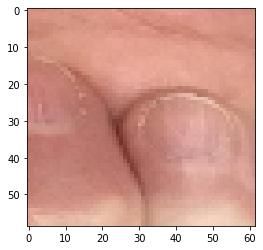

tensor(0.7434, grad_fn=<SelectBackward0>)
245 280 301 329 20211026154550_pid2625_s88UCf.jpg


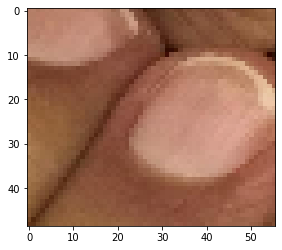

tensor(0.5051, grad_fn=<SelectBackward0>)
253 241 327 305 20211026155836_pid2625_5p2ds3.jpg


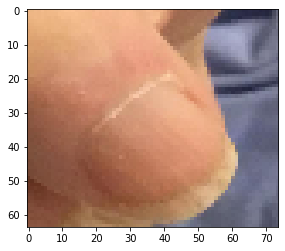

tensor(0.7638, grad_fn=<SelectBackward0>)
206 188 267 256 20211026161013_pid2625_PvRdH2.jpg


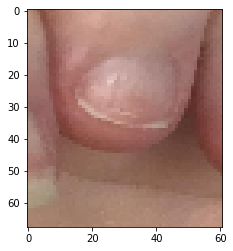

tensor(0.5015, grad_fn=<SelectBackward0>)
166 247 230 298 20211026162715_pid2625_3v9Rsk.jpg


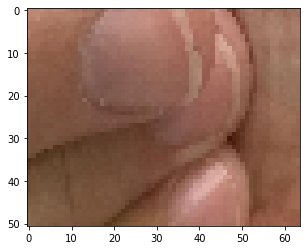

tensor(0.6955, grad_fn=<SelectBackward0>)
200 281 254 327 20211026164450_pid2625_t8ogI4.jpg


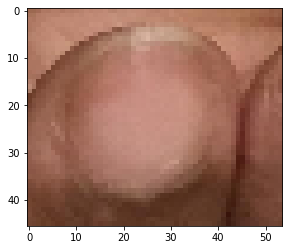

tensor(0.3498, grad_fn=<SelectBackward0>)
260 302 342 361 20211026165626_pid2625_Bt4wDw.jpg


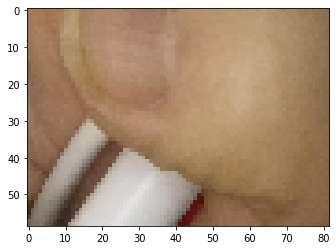

tensor(0.4661, grad_fn=<SelectBackward0>)
20 129 92 173 20211026170959_pid2625_kiJFS5.jpg


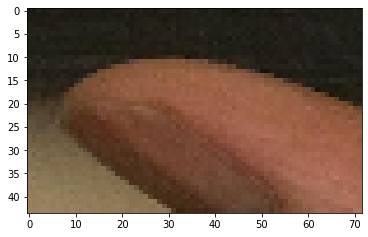

tensor(0.5030, grad_fn=<SelectBackward0>)
181 250 239 298 20211026172354_pid2625_y6eTuU.jpg


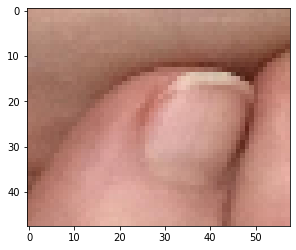

tensor(0.6345, grad_fn=<SelectBackward0>)
115 275 177 320 20211029095422_pid2625_gxkmIn.jpg


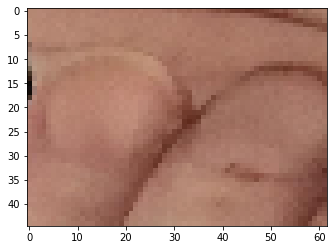

tensor(0.6322, grad_fn=<SelectBackward0>)
176 265 236 319 20211029100901_pid2625_8qes75.jpg


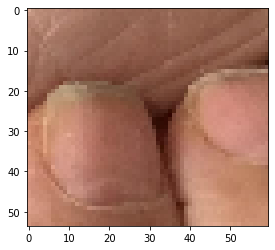

tensor(0.7434, grad_fn=<SelectBackward0>)
127 279 197 328 20211029101726_pid2625_JafHSM.jpg


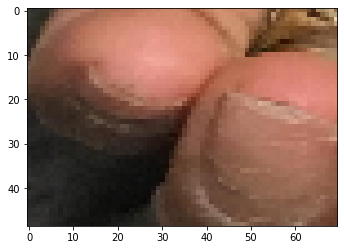

tensor(0.5149, grad_fn=<SelectBackward0>)
116 135 200 194 20211029103007_pid2625_6Z2djE.jpg


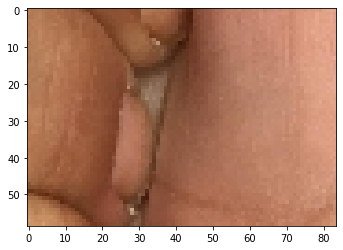

tensor(0.4090, grad_fn=<SelectBackward0>)
252 302 320 362 20211029104501_pid2625_oRhW6J.jpg


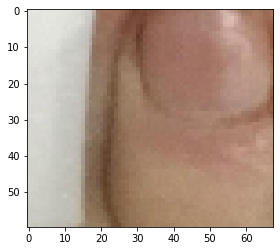

tensor(0.7487, grad_fn=<SelectBackward0>)
303 178 364 226 20211029105809_pid2625_6Fv9Jj.jpg


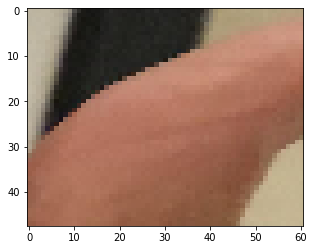

tensor(0.6622, grad_fn=<SelectBackward0>)
0 201 67 288 20211029113521_pid2625_9I29xS.jpg


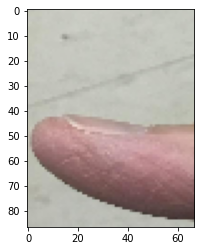

tensor(0.5580, grad_fn=<SelectBackward0>)
220 268 282 318 20211029114748_pid2625_cgHopd.jpg


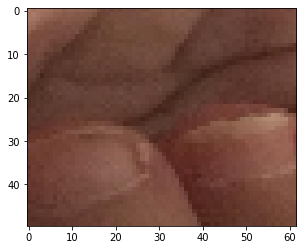

tensor(0.8384, grad_fn=<SelectBackward0>)
178 268 254 328 20211029115751_pid2625_zgyxzj.jpg


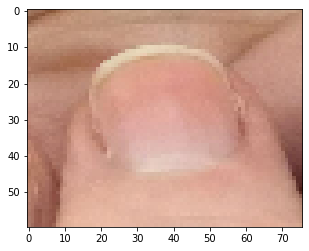

In [21]:
import random
from PIL import Image
pre_path = "../../../DL_data/competition2/datalab-2021-cup2-object-detection/"

if not os.path.exists("../data/crop_nail_image"):
    os.mkdir("../data/crop_nail_image")
test_img_files = open('../data/'+mode+'.txt')
test_img_dir = "../data/image/"
test_images = []

mean_rgb = global_mean
std_rgb=global_std
mean = np.array(mean_rgb, dtype=np.float32)
std = np.array(std_rgb, dtype=np.float32)
image_size=448
yolo.to("cuda")
num = int(random.random()*length)
print(length)
count = 0
for line in test_img_files:
#     if(count!=num):
#         count+=1
#         continue
    line = line.strip()
    ss = line.split(' ')
    img = cv2.imread(test_img_dir+ss[0])
#     origin_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
    origin_shape = img.shape
#     origin_image = read_image(test_img_dir+ss[0])
#     print(origin_shape)
    x_ratio = origin_shape[1]/image_size
    y_ratio = origin_shape[0]/image_size
#     print(x_ratio, y_ratio)
    img = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # assuming the model is pretrained with RGB images.
    origin_image = img.copy()
    img = (img - mean) / std # normalize from -1.0 to 1.0.
    img = tx.to_tensor(img)
    img = img.to("cuda")
    img = img.reshape((1,3,image_size,image_size))
    prediction = yolo(img)
    prediction = prediction.to("cpu")
    decode_pred = decode(prediction[0])
    sorted_conf = torch.sort(decode_pred[2]).values
#     print(decode_pred)
    pick = []
    for i in range(1):
        pick.append(sorted_conf[sorted_conf.shape[0]-1-i])
        print(sorted_conf[sorted_conf.shape[0]-1-i])

    for i in range(len(decode_pred[2])):
        if decode_pred[2][i] in pick:
#             cv2.rectangle(origin_image, (int(decode_pred[0][i][0]), int(decode_pred[0][i][1])), (int(decode_pred[0][i][2]), int(decode_pred[0][i][3])), (0, 255, 0), 3)
            xmin = int(decode_pred[0][i][0])
            ymin = int(decode_pred[0][i][1])
            xmax = int(decode_pred[0][i][2])
            ymax = int(decode_pred[0][i][3])
    xmin = max(0,xmin)
    xmax = max(0,xmax)
    ymin = max(0,ymin)
    ymax = max(0,ymax)
    print(xmin,ymin,xmax,ymax, ss[0])
    crop_image = origin_image[ymin:ymax,xmin:xmax]
    save_image = Image.fromarray(crop_image)
    save_image.save("../data/crop_nail_image/"+ss[0])
#     plt.imshow(origin_image)
    plt.imshow(crop_image)
    plt.show()
#     break

In [29]:
yolo.eval()
pre_path = "../../../DL_data/competition2/datalab-2021-cup2-object-detection/"
test_img_files = open("../data/valid.txt")
test_img_dir = "../data/image/"
test_images = []
mean_rgb = global_mean
std_rgb=global_std
mean = np.array(mean_rgb, dtype=np.float32)
std = np.array(std_rgb, dtype=np.float32)
image_size=448
output_file = open('./valid_prediction.txt', 'w')
count = 0
yolo.to("cuda")
for line in test_img_files:
#         if count%500==0:
#             print(count)
    line = line.strip()
    ss = line.split(' ')
    img = cv2.imread(test_img_dir+ss[0])
    origin_shape = img.shape
#     print(origin_shape)
    x_ratio = origin_shape[1]/image_size
    y_ratio = origin_shape[0]/image_size
#     print(x_ratio, y_ratio)
    img = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = (img - mean) / std # normalize from -1.0 to 1.0.
    if to_gray:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = tx.to_tensor(img)
    img = img.to("cuda")
    if to_gray:
        img = img.reshape((1,1,image_size,image_size))
    else:
        img = img.reshape((1,3,image_size,image_size))

    prediction = yolo(img)
    prediction = prediction.to("cpu")

    decode_pred = decode(prediction[0])
#     print(decode_pred)
#     print(len(decode_pred[0]))
    for i in range(len(decode_pred[0])):
#     for i in range(5):
#         x_min = min(int(x_ratio*decode_pred[0][i][0]), int(x_ratio*decode_pred[0][i][2]))
#         x_max = max(int(x_ratio*decode_pred[0][i][0]), int(x_ratio*decode_pred[0][i][2]))
#         y_min = min(int(y_ratio*decode_pred[0][i][1]), int(y_ratio*decode_pred[0][i][3]))
#         y_max = max(int(y_ratio*decode_pred[0][i][1]), int(y_ratio*decode_pred[0][i][3]))
        decode_pred[0][i][0]=int(x_ratio*decode_pred[0][i][0])
        decode_pred[0][i][2]=int(x_ratio*decode_pred[0][i][2])
        decode_pred[0][i][1]=int(y_ratio*decode_pred[0][i][1])
        decode_pred[0][i][3]=int(y_ratio*decode_pred[0][i][3])
#     print(decode_pred)
    s=ss[0]+" "
    for i in range(len(decode_pred[0])):
#     for i in range(5):
        if decode_pred[2][i]<0.1:
            continue
        for j in range(4):
            s+=str(decode_pred[0][i][j].item())+" "
        s+=str(decode_pred[1][i].item())+" "
        s+=str(decode_pred[2][i].item())+" "
    s+="\n"
    output_file.write(s)
    count+=1
    if few_data:
        if count==data_num:
            break
#     break
output_file.close()
import sys
#     sys.path.insert(0, pre_path+'./evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./valid_prediction.txt', './valid_output_file.csv', "valid", "../data/valid.txt")
valid_csv = pd.read_csv("valid_output_file.csv")
MSE = 0
for i in range(len(valid_csv["packedCAP"])):
    MSE+=(1-valid_csv["packedCAP"][i])**2
print(MSE)

0.6180573143095676


In [28]:
import evaluate
import pandas as pd
mode = "valid"
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./'+mode+'_prediction.txt', './'+mode+'_output_file.csv', mode, "../data/"+mode+".txt")
train_csv = pd.read_csv(mode+"_output_file.csv")
MSE = 0

for i in range(len(train_csv["packedCAP"])):
    MSE+=(1-train_csv["packedCAP"][i])**2
print(MSE)

0.34092410322896827
